# Q-Learning Numpy
 Using Q-learning implemented on Numpy to play Frozen Lake environment on OpenAI Gym.

## CartPole-v1
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [1]:
import gym
import numpy as np
import seaborn as sns

In [2]:
# Create GYM environment
env = gym.make("CartPole-v1")

In [3]:
# Observation bounds
obs_low = env.observation_space.low
obs_high = env.observation_space.high
print(obs_low)
print(obs_high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [13]:
# Bins to digitize position, angle, and angular velocity
resolution = 20
bins = [np.linspace(obs_low[0], obs_high[0], resolution),
        np.linspace(-10., 10., resolution),
        np.linspace(obs_low[2], obs_high[2], resolution),
        np.linspace(-10., 10., resolution)]

In [14]:
# Number of actions and states
action_size = env.action_space.n
state_size = env.observation_space.shape

In [22]:
# Initialize q-table
res = resolution + 1
qtable = np.zeros((res, res, res, res, action_size))
print(qtable.shape)

(21, 21, 21, 21, 2)


In [31]:
# Hyperparameters
total_episodes = 15000      # Total episodes
learning_rate = 0.8         # Learning rate
max_steps = 100             # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 1.0               # Exploration rate
max_epsilon = 1.0           # Exploration probability at start
min_epsilon = 0.01          # Minimum exploration probability 
decay_rate = 0.005          # Exponential decay rate for exploration prob

In [32]:
def get_dstates(c_states, bins):
    d_states = []
    for i, s in enumerate(c_states):
        d_states.append(np.digitize(s, bins[i]))
    return tuple(d_states)

In [33]:
# FILL Q-TABLE

# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    # Reset the environment
    states = env.reset()
    dstates = get_dstates(states, bins)
    step = 0
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        # 3. Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = np.random.uniform(0, 1)
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[dstates])

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)
        new_dstates = get_dstates(new_state, bins)
        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        ind = dstates + (action,)
        qtable[ind] = (qtable[ind] + 
                       learning_rate * (reward + gamma * np.max(qtable[new_dstates]) -
                                        qtable[ind]))
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        dstates = new_dstates
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode) 
    rewards.append(total_rewards)

print ("Score over time: " +  str(sum(rewards)/total_episodes))

Score over time: 22.065533333333335


In [34]:
for episode in range(5):
    states = env.reset()
    dstates = get_dstates(states, bins)
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        action = np.argmax(qtable[dstates])
        
        new_state, reward, done, info = env.step(action)
        new_dstates = get_dstates(new_state, bins)
        ind = dstates + (action,)
        env.render()
        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            # We print the number of step it took.
            print("Number of steps", step)
            break
        state = new_state
        dstates = new_dstates
env.close()

****************************************************
EPISODE  0
Number of steps 16
****************************************************
EPISODE  1
Number of steps 17
****************************************************
EPISODE  2
Number of steps 24
****************************************************
EPISODE  3
Number of steps 23
****************************************************
EPISODE  4
Number of steps 25


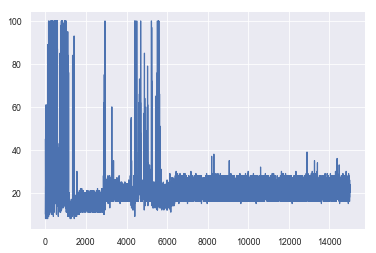

In [35]:
# Rewards
sns.lineplot(range(len(rewards)), rewards)

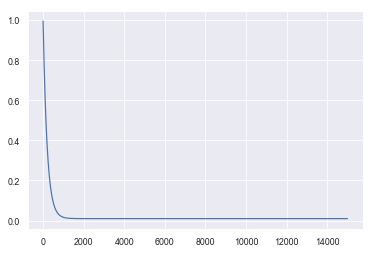

In [36]:
# Rewards
x = np.arange(1, total_episodes)
y = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*x) 
sns.lineplot(x, y)